In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('smart.csv')

features_col = ['Raw Read Error Rate','SpinUpTime','Reallocated Sector Count','Seek Error Rate', \
                'Power on Hours','Reported Uncorrectable Error', 'High Fly Writes', \
                'Temperature Celsius', 'Hardware ECC Recovered', 'Current Pending Sector', 'Reallocated Sectors Count', \
                'Current Pending Sectors counts']

X = df[features_col].to_numpy()
y = df['Drive Status'].to_numpy()

In [3]:

scaler = StandardScaler()
X = scaler.fit_transform(X)

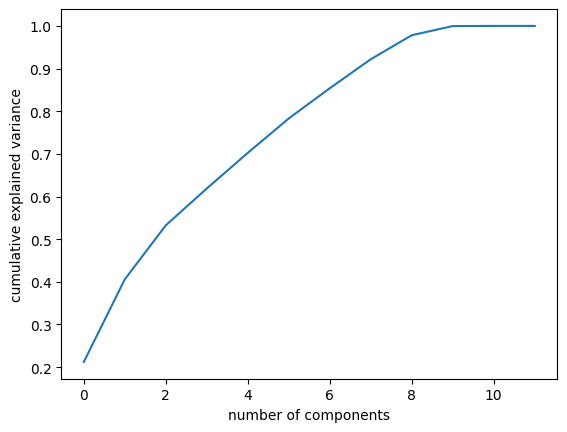

In [4]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [5]:
pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

In [6]:

X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=0.2
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=0.25
)


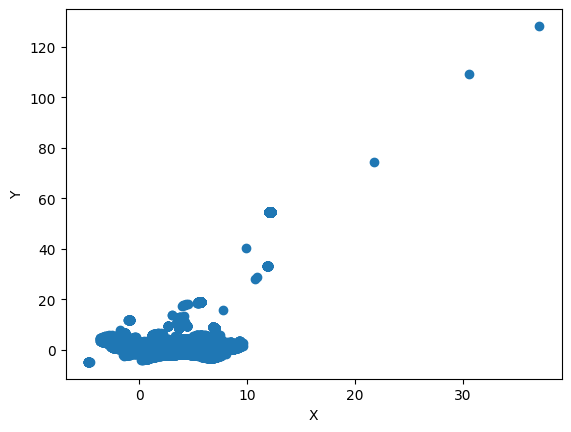

In [7]:

fig = plt.figure()
plt.scatter(
    X_train[:, 0],
    X_train[:, 1]
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [8]:
clf = GaussianNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba_max = np.max(y_pred_proba, axis=1)
mapie_score = MapieClassifier(estimator=clf, cv="prefit", method="mondrian")
mapie_score.fit(X_cal, y_cal)
alpha = [0.2, 0.1, 0.05]
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)


In [9]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#100f0e"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

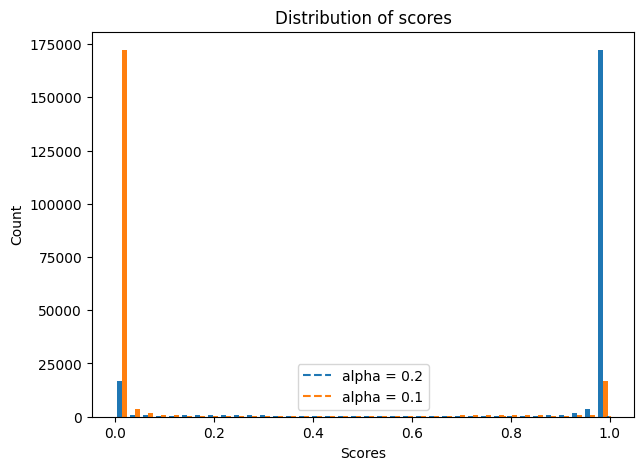

In [10]:
scores = mapie_score.conformity_scores_
n = len(mapie_score.conformity_scores_)
quantiles = mapie_score.quantiles_
plot_scores(n, alpha, scores, quantiles)

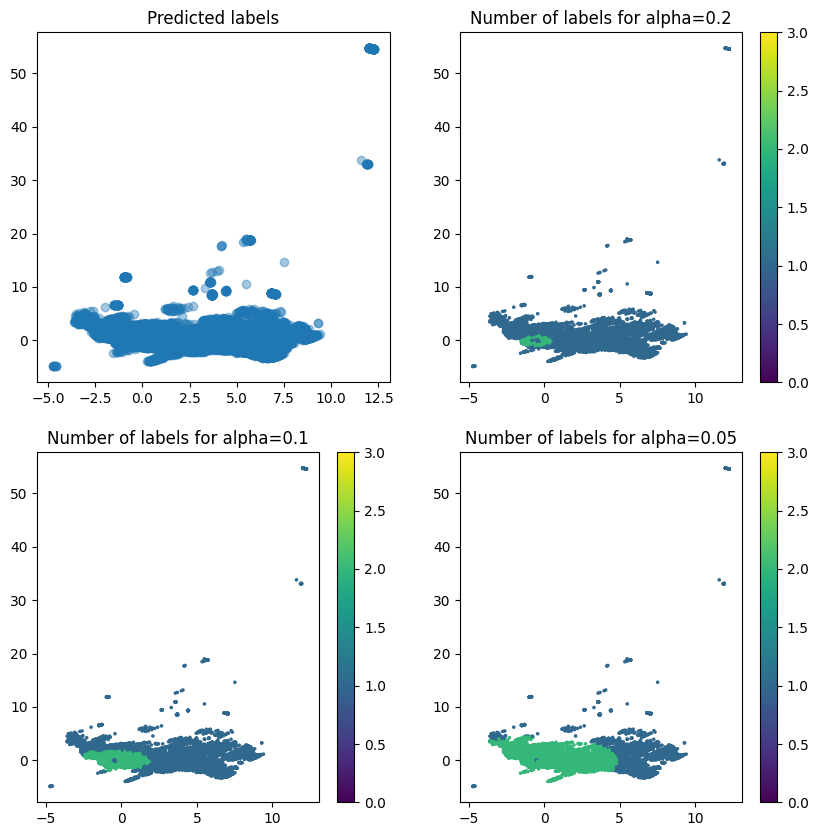

In [11]:

def plot_results(alphas, X, y_pred, y_ps):
    #tab10 = plt.cm.get_cmap('Purples', 4)
    #colors = {0: "#1f77b4", 1: "#ff7f0e", 2:  "#2ca02c", 3: "#d62728"}
    #y_pred_col = list(map(colors.get, y_pred))
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))
    axs = {0: ax1, 1: ax2, 2:  ax3, 3: ax4}
    axs[0].scatter(
        X[:, 0],
        X[:, 1],
     #   color=y_pred_col,
     #   marker='.',
     #   s=10,
        alpha=0.4
    )
    axs[0].set_title("Predicted labels")
    for i, alpha in enumerate(alphas):
        y_pi_sums = y_ps[:, :, i].sum(axis=1)
        num_labels = axs[i+1].scatter(
            X[:, 0],
            X[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            #cmap=tab10,
            vmin=0,
            vmax=3
        )
        plt.colorbar(num_labels, ax=axs[i+1])
        axs[i+1].set_title(f"Number of labels for alpha={alpha}")
    plt.show()


plot_results(alpha, X_test, y_pred_score, y_ps_score)

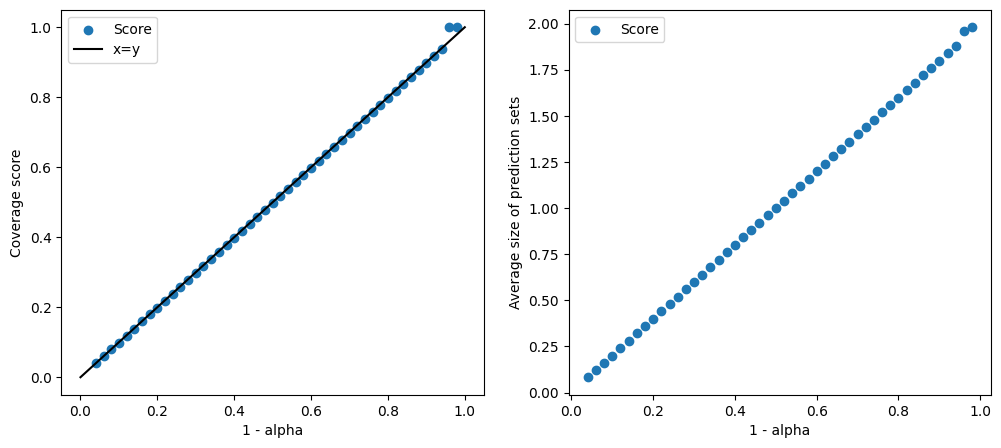

In [12]:
alpha2 = np.arange(0.02, 0.98, 0.02)
_, y_ps_score2 = mapie_score.predict(X_test, alpha=alpha2)
coverages_score = [
    classification_coverage_score(y_test, y_ps_score2[:, :, i])
    for i, _ in enumerate(alpha2)
]
widths_score = [
    classification_mean_width_score(y_ps_score2[:, :, i])
    for i, _ in enumerate(alpha2)
]


def plot_coverages_widths(alpha, coverage, width, method):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(1 - alpha, coverage, label=method)
    axs[0].set_xlabel("1 - alpha")
    axs[0].set_ylabel("Coverage score")
    axs[0].plot([0, 1], [0, 1], label="x=y", color="black")
    axs[0].legend()
    axs[1].scatter(1 - alpha, width, label=method)
    axs[1].set_xlabel("1 - alpha")
    axs[1].set_ylabel("Average size of prediction sets")
    axs[1].legend()
    plt.show()


plot_coverages_widths(alpha2, coverages_score, widths_score, "Score")

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

X_train, X_rest1, y_train, y_rest1 = train_test_split(
X, y, train_size=500, random_state=2
)
# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(
X_rest1, y_rest1, train_size=400, random_state=42
)
# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(
X_rest2, y_rest2, train_size=200, random_state=42
)

# Fit the model
model = LogisticRegression(random_state=0).fit(X_train, y_train)

In [17]:
from sklearn.metrics import confusion_matrix
# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm))

Accuracy: 0.905
    0    1
0  35   35
1   3  327


In [18]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05
# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(scores, q_level)

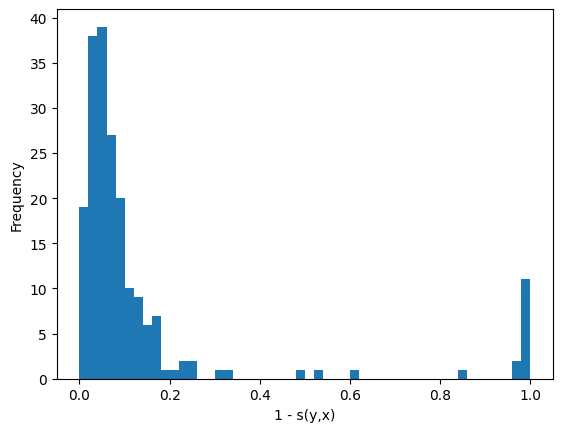

In [19]:
import matplotlib.pyplot as plt
# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)
# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]
# Create a histogram
plt.hist(1 - prob_for_true_class, bins=50, range=(0, 1))
# Add a title and labels
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequency")
plt.show()

In [20]:
prediction_sets = (1 - model.predict_proba(X_new) <= qhat)

In [21]:
from mapie.classification import MapieClassifier
cp = MapieClassifier(estimator=model, cv="prefit", method="mondrian")
cp.fit(X_calib, y_calib)
y_pred, y_set = cp.predict(X_new, alpha=0.15)
y_set = np.squeeze(y_set)

In [22]:
# first count number of classes per bean
set_sizes = y_set.sum(axis=1)
# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

2    710913
1    336560
dtype: int64


In [23]:
y_pred, y_set = cp.predict(X_new, alpha=0.01)
# remove the 1-dim dimension
y_set = np.squeeze(y_set)
# first count number of classes per bean
set_sizes = y_set.sum(axis=1)
# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

2    1033213
1      14260
dtype: int64


## CP

In [24]:
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print('Avg. set size: {:.2f}'.format(setsize))

Coverage: 99.40%
Avg. set size: 1.99


In [25]:
mapie_score = MapieClassifier(model, cv='prefit', method='mondrian')
mapie_score.fit(X_calib, y_calib)
y_pred, y_set = mapie_score.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)

In [26]:
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print("Avg. set size: {:.2f}".format(setsize))

Coverage: 95.67%
Avg. set size: 1.93


In [27]:
from sklearn.metrics import confusion_matrix
# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm))

Accuracy: 0.905
    0    1
0  35   35
1   3  327


In [28]:
from typing import Any, Dict, List, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from typing_extensions import TypedDict

from mapie._typing import NDArray
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)

In [29]:
kf = KFold(n_splits=5, shuffle=True)
clfs, mapies, y_preds, y_ps_mapies = {}, {}, {}, {}
methods = ["mondrian"]
alpha = np.arange(0.01, 1, 0.01)
for method in methods:
    clfs_, mapies_, y_preds_, y_ps_mapies_ = {}, {}, {}, {}
    for fold, (train_index, calib_index) in enumerate(kf.split(X_train)):
        clf = GaussianNB().fit(X_train[train_index], y_train[train_index])
        clfs_[fold] = clf
        mapie = MapieClassifier(estimator=clf, cv="prefit", method=method)
        mapie.fit(X_train[calib_index], y_train[calib_index])
        mapies_[fold] = mapie
        y_pred_mapie, y_ps_mapie = mapie.predict(
            X_test, alpha=alpha, include_last_label="randomized"
        )
        y_preds_[fold], y_ps_mapies_[fold] = y_pred_mapie, y_ps_mapie
    clfs[method], mapies[method], y_preds[method], y_ps_mapies[method] = (
        clfs_, mapies_, y_preds_, y_ps_mapies_
    )

In [30]:
def plot_results(
        mapies: Dict[int, Any],
        X_test: NDArray,
        X_test2: NDArray,
        y_test2: NDArray,
        alpha: float,
        method: str
) -> None:
    #tab10 = plt.cm.get_cmap('Purples', 4)
    fig, axs = plt.subplots(1, len(mapies), figsize=(20, 4))
    for i, (_, mapie) in enumerate(mapies.items()):
        y_pi_sums = mapie.predict(
            X_test,
            alpha=alpha,
            include_last_label=True
        )[1][:, :, 0].sum(axis=1)
        axs[i].scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            #cmap=tab10,
            vmin=0,
            vmax=3
        )
        coverage = classification_coverage_score(
            y_test2, mapie.predict(X_test2, alpha=alpha)[1][:, :, 0]
        )
        axs[i].set_title(f"coverage = {coverage:.3f}")
    plt.suptitle(
        "Number of labels in prediction sets "
        f"for the {method} method"
    )
    plt.show()

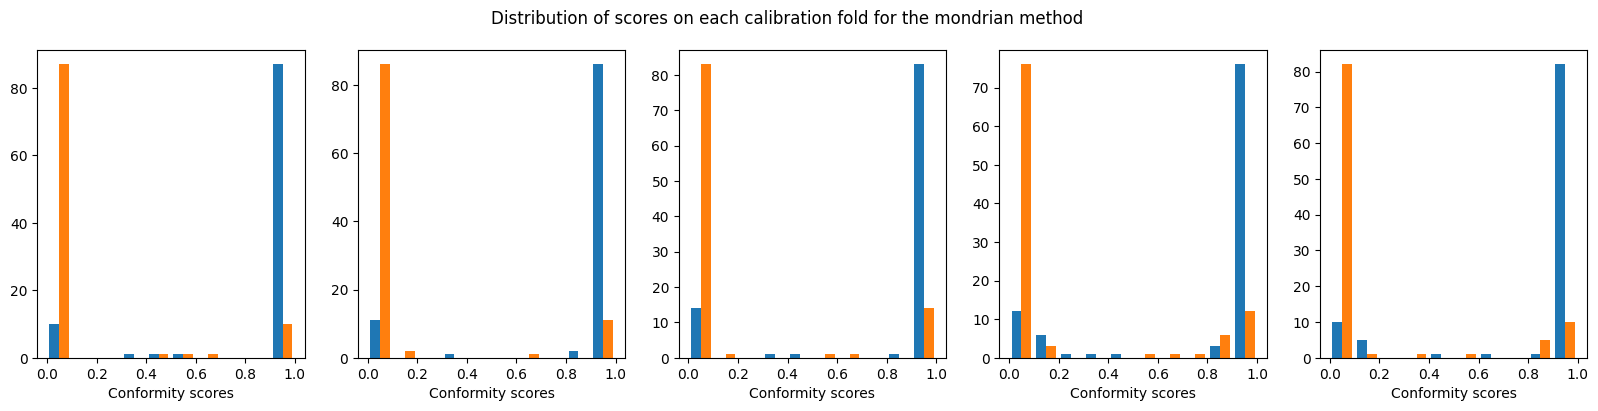

In [31]:
fig, axs = plt.subplots(1, len(mapies["mondrian"]), figsize=(20, 4))
for i, (key, mapie) in enumerate(mapies["mondrian"].items()):
    axs[i].set_xlabel("Conformity scores")
    axs[i].hist(mapie.conformity_scores_)
    #axs[i].axvline(mapie.quantiles_[1], ls="--", color="k")
    #axs[i].set_title(f"split={key}\nquantile={mapie.quantiles_[9]:.3f}")
plt.suptitle(
    "Distribution of scores on each calibration fold for the "
    f"{methods[0]} method"
)
plt.show()

In [32]:
def plot_results(
        mapies: Dict[int, Any],
        X_test: NDArray,
        X_test2: NDArray,
        y_test2: NDArray,
        alpha: float,
        method: str
) -> None:
    #tab10 = plt.cm.get_cmap('Purples', 4)
    fig, axs = plt.subplots(1, len(mapies), figsize=(20, 4))
    for i, (_, mapie) in enumerate(mapies.items()):
        y_pi_sums = mapie.predict(
            X_test,
            alpha=alpha,
            include_last_label=True
        )[1][:, :, 0].sum(axis=1)
        axs[i].scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_pi_sums,
            marker='.',
            s=10,
            alpha=1,
            #cmap=tab10,
            vmin=0,
            vmax=3
        )
        coverage = classification_coverage_score(
            y_test2, mapie.predict(X_test2, alpha=alpha)[1][:, :, 0]
        )
        axs[i].set_title(f"coverage = {coverage:.3f}")
    plt.suptitle(
        "Number of labels in prediction sets "
        f"for the {method} method"
    )
    plt.show()

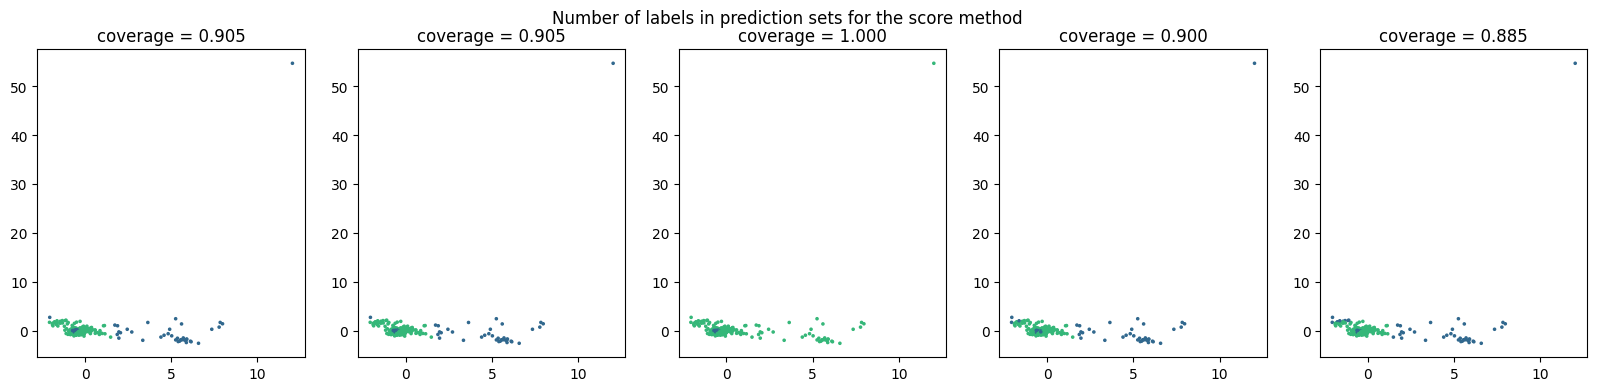

In [33]:
plot_results(
    mapies["mondrian"],
    X_test,
    X_test,
    y_test,
    alpha[9],
    "score"
)



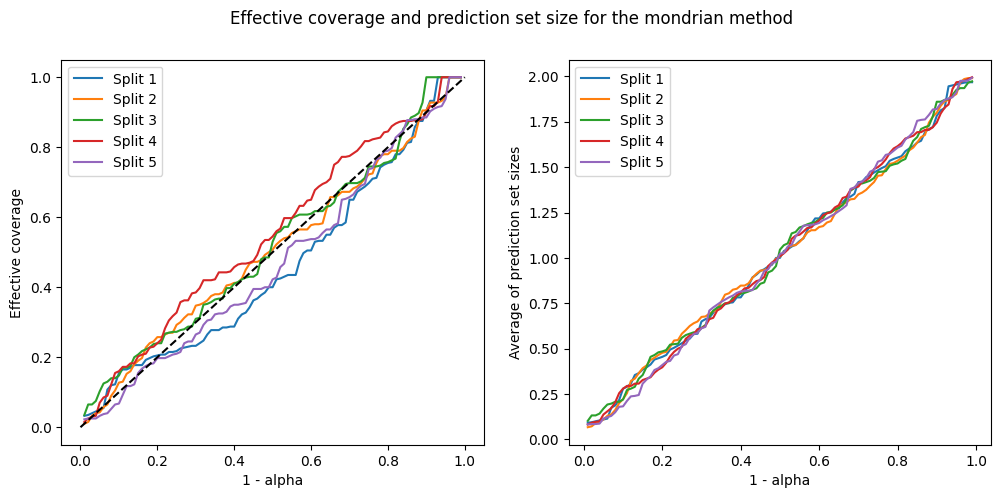

In [34]:
def plot_coverage_width(
        alpha: NDArray,
        coverages: List[NDArray],
        widths: List[NDArray],
        method: str,
        comp: str = "split"
) -> None:
    if comp == "split":
        legends = [f"Split {i + 1}" for i, _ in enumerate(coverages)]
    else:
        legends = ["Mean", "Crossval"]
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    axes[0].set_xlabel("1 - alpha")
    axes[0].set_ylabel("Effective coverage")
    for i, coverage in enumerate(coverages):
        axes[0].plot(1 - alpha, coverage, label=legends[i])
    axes[0].plot([0, 1], [0, 1], ls="--", color="k")
    axes[0].legend()
    axes[1].set_xlabel("1 - alpha")
    axes[1].set_ylabel("Average of prediction set sizes")
    for i, width in enumerate(widths):
        axes[1].plot(1 - alpha, width, label=legends[i])
    axes[1].legend()
    plt.suptitle(
        "Effective coverage and prediction set size "
        f"for the {method} method"
    )
    plt.show()


split_coverages = np.array(
    [
        [
            [
                classification_coverage_score(
                    y_test, y_ps[:, :, ia]
                ) for ia, _ in enumerate(alpha)]
            for _, y_ps in y_ps2.items()
        ] for _, y_ps2 in y_ps_mapies.items()
    ]
)

split_widths = np.array(
    [
        [
            [
                classification_mean_width_score(y_ps[:, :, ia])
                for ia, _ in enumerate(alpha)
            ]
            for _, y_ps in y_ps2.items()
        ] for _, y_ps2 in y_ps_mapies.items()
    ]
)

plot_coverage_width(
    alpha, split_coverages[0], split_widths[0], "mondrian"
)

